<h3>This example show the solution of synchronous machine with load.</h3>

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos,pi,complex,sqrt,abs

In [64]:
#RK4Solver class
class RK4Solver:

  def __init__(self, s_i, dt,t0,time,ndim, system_of_equations):
    self.dt = dt
    self.t0 = t0
    self.time = time
    self.s = s_i
    self.system_of_equations = system_of_equations
    self.ndim = ndim
    self.steps = int(self.time/self.dt)
    self.state_solution = np.zeros((self.ndim,self.steps))
    self.time_solution = np.zeros((1, self.steps))
    self.index = 0;

    #taking single step RK4
  def RK4Step(self,s, dt, t, derivs):
      f1 = derivs(s, t)
      f2 = derivs(s+f1*dt/2.0, t+dt/2.0)
      f3 = derivs(s+f2*dt/2.0, t+dt/2.0)
      f4 = derivs(s+f3*dt, t+dt)
      return s + (f1+2*f2+2*f3+f4)*dt/6.0

  def Run_solver(self):
    for step in  range(self.steps):
      
      self.time_solution[0][self.index] = self.t0
      for i in range(self.ndim):
        self.state_solution[i][self.index] = self.s[i].item()

      self.s = self.RK4Step(self.s, self.dt, self.time, self.system_of_equations)
      self.t0 = self.t0 + self.dt
      self.index = self.index+1
      
    return np.array([self.state_solution,self.time_solution])

In [65]:
def dq0_abc_transform(v_d,v_q,v_0,omega,t_sol):
  wt = omega*np.array(t_sol);
  one = np.ones(len(wt))
  a = cos(wt)*v_d - sin(wt)*v_q + one*v_0
  b = cos(wt-2*pi/3)*v_d -sin(wt-2*pi/3)*v_q + one*v_0
  c = cos(wt+2*pi/3)*v_d -sin(wt+2*pi/3)*v_q + one*v_0
  return np.array([a,b,c])

In [66]:
Base_kva = 8.1 
Base_kv = 0.4/sqrt(3)
Base_kv_peak = sqrt(2)*Base_kv
Base_i = Base_kva/(3*Base_kv)
Base_i_peak = sqrt(2)*Base_i
f_base = 50
omega_base = 2*pi*f_base
poles = 2
omega_m_base = omega_base*(2/poles)
Z_sbase = Base_kv*1000/Base_i
Torque_base = Base_kva*1000/omega_m_base

<h2>Synchronous Machine With Load and ELC</h2>
<h3>Synchronous Machine Modelling Equations</h3>

<h4> Differential Equations</h4>
$$T_{d0}' \frac{dE_q'}{dt} = - E_q' - (X_d - X_d') I_d + E_{fd}$$
$$T_{q0}' \frac{dE_d'}{dt} = -E_d' - (X_q - X_q')I_q$$

$$\frac{d\delta}{dt} = \Delta ω$$

$$J\frac{d\Delta\omega}{dt} = P_m - P_{ei} - D \Delta \omega$$

$$P_{ei} = [ E_q'I_q + E_d'I_d - (X_d'-X_q')I_dI_q]$$

<h4> Algebraic Equations</h4>

$$V_d = E_d' - R_{sg}I_{d} + I_{q}X_q'$$
$$V_q = E_q' - I_{d}X_d' - I_{q}R_{sg}$$





<h3>ELC Modelling Equations</h3>


<h3>Transmission Line Equation</h3>
$$L_1\frac{dI_d}{dt} = ω_sL_1I_q - R_1I_{d} + V_d - V_{dL}$$

$$L_1\frac{dI_q}{dt} = -ω_sL_1I_d - R_1I_{q} + V_q - V_{dL}$$

$L_1 = L_s - L_m$,
$R_1 = R_s - R_m$
<h3>Load Modelling Equations</h3>

$$I_{dL} = I_{d}$$
$$I_{qL} = I_{q}$$

$$I_{load} = I_{dL} + jI_{qL}$$
$$Z_{load} = R_{load} + jX_{load}$$
$$V_{load} = I_{load}Z_{load}$$
$$V_{load} = V_{dL} + jV_{qL}$$
$$S_{load} = I_{load}^* V_{load}$$

In [67]:
#machine parameters

X_dd = 0.296
X_d = 1.56
X_q = 2
X_qd = 0.4
T_dod = 3.7
T_qod = 0.6
D = 0.0005
J = 20
R_sg = 0.0

#excitation system paramters
T_A = 0.05
K_A = 200
V_ref = 1.15

#Governor system parameters
T_sv = 0.05
P_ref = 1
R_d = 0.05
T_ch =0.5 

#transmission line parameters
L_s = 0.5/(omega_base)
L_m = 0.0000
R_s = 0.018
R_m = 0.000
omega_0 = 2*pi*50/omega_base
L_1 = L_s - L_m
R_1 = R_s - R_m

#load parameters
#p = v2/R
#R = V2/p

##Rate load is 1 pu
R_load = 4
X_load = 0
Load = complex(R_load,X_load)

##ELC paramters


In [68]:
def system_of_equations(s, t):
  #state variables
    d_omega = s[0]
    delta =s[1]
    E_qd = s[2]
    E_dd = s[3]

    T_m = s[4]
    
    P_sv = s[5]

    E_fd = s[6]

    I_ds = s[7]
    I_qs = s[8]

    
    
   
    
    
    V_ds = E_dd - R_sg*I_ds + I_qs*X_qd
    V_qs = E_qd - I_ds*X_dd - I_qs*R_sg
    V_t = abs(complex(V_ds,V_qs))

    P_ei = E_dd*I_ds + E_qd*I_qs - (X_dd-X_qd)*I_ds*I_qs
    T_ei = P_ei
    

    d_omega_dot = (1/(J)) *(T_m - T_ei + D*(d_omega))
    delta_dot = d_omega
    E_qd_dot = (1/T_dod) *(-E_qd - (X_d - X_dd)*I_ds + E_fd)
    E_dd_dot = (1/T_qod) *(-E_dd + (X_q - X_qd)*I_qs)
    
    #Exciter Model

    E_fd_dot = (1/T_A)*(-E_fd + K_A*(V_ref- V_t))

    #Governor Model
    P_sv_dot = (1/T_sv)*(-P_sv + P_ref - (1/(R_d)*d_omega))
    T_m_dot = (1/T_ch)*(-T_m + P_sv)

    I_s = complex(I_ds,I_qs)
    
    
    V_Load = (I_s)*Load
    V_dL = np.real(V_Load)
    V_qL = np.imag(V_Load)

    I_ds_dot = (1/L_1)*(omega_base*L_1*I_qs - R_1*I_ds + V_ds - V_dL)
    I_qs_dot = (1/L_1)*(-omega_base*L_1*I_ds - R_1*I_qs + V_qs - V_qL)
    

    return np.array([d_omega_dot, delta_dot,E_qd_dot,E_dd_dot,T_m_dot, P_sv_dot, E_fd_dot, I_ds_dot, I_qs_dot])

In [69]:
#Initillization of parameters
d_omega_i = 0
delta_i= 0.0
E_qd_i = 0
E_dd_i = 0
P_sv_i = 0.0
E_fd_i = 0
T_m_i = 0.0
I_ds_i = 0
I_qs_i = 0


s_i = np.array([d_omega_i, delta_i,E_qd_i,E_dd_i,T_m_i,P_sv_i, E_fd_i, I_ds_i, I_qs_i]) # initial state
dt = 0.0001
time = 10
t0 = 0
ndim = len(s_i)

In [70]:
solver1 = RK4Solver(s_i,dt,t0,time,ndim,system_of_equations)
sol = solver1.Run_solver()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [71]:
d_omega, delta,E_qd,E_dd, T_m,P_sv, E_fd, I_ds, I_qs = sol[0] 
t = sol[1][0]
j = complex(0,1)
V_ds = E_dd - R_sg*I_ds + I_qs*X_qd
V_qs = E_qd - I_ds*X_dd - I_qs*R_sg
V_ts = (V_ds+j*V_qs)
I_ts = (I_ds + j*I_qs)



v_0 = np.zeros(len(t))
i_0 = np.zeros(len(t))

V_Load = I_ts*Load

V_dL = np.real(V_Load)
V_qL = np.imag(V_Load)

omega = omega_base + d_omega*omega_base

abcvs = dq0_abc_transform(V_ds,V_qs,v_0,omega,t)
abcv = dq0_abc_transform(V_dL,V_qL,v_0,omega,t)
abci = dq0_abc_transform(I_ds,I_qs,i_0,omega,t)

load_power = np.conj(I_ts)*V_Load
apower = np.real(load_power)
qpower = np.imag(load_power)

Torque = T_m * Torque_base
Mech_Power = Torque*omega_m_base

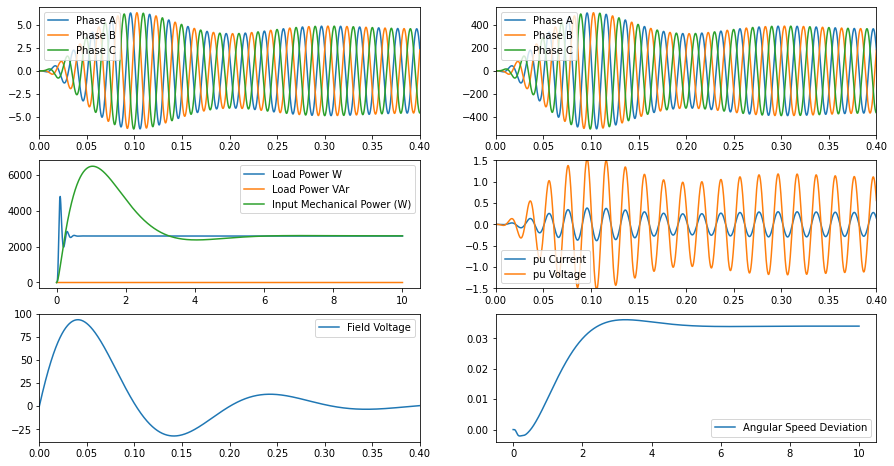

In [72]:
xlimit = [0,0.4]
fig, axs = plt.subplots(3, 2,figsize=(15,8))
axs[0, 0].plot(t,abci[0]*Base_i_peak,label ='Phase A')
axs[0, 0].plot(t,abci[1]*Base_i_peak, label = "Phase B")
axs[0, 0].plot(t,abci[2]*Base_i_peak, label = "Phase C")
axs[0, 0].set_xlim(xlimit)
axs[0, 0].legend()

axs[0, 1].plot(t,abcv[0]*Base_kv_peak*1000,label ='Phase A')
axs[0, 1].plot(t,abcv[1]*Base_kv_peak*1000, label = "Phase B")
axs[0, 1].plot(t,abcv[2]*Base_kv_peak*1000, label = "Phase C")
axs[0, 1].set_xlim(xlimit)
axs[0, 1].legend()

axs[1,0].plot(t,apower*Base_kva*1000, label= "Load Power W")
axs[1,0].plot(t,qpower*Base_kva*1000, label= "Load Power VAr")
axs[1,0].plot(t,Mech_Power, label = "Input Mechanical Power (W)")
axs[1,0].legend()

axs[1,1].plot(t,abci[0], label = "pu Current")
axs[1,1].plot(t,abcv[0], label = "pu Voltage")
axs[1,1].legend()
axs[1,1].set_xlim(xlimit)
axs[1,1].set_ylim([-1.5,1.5])

axs[2,0].plot(t,E_fd, label = "Field Voltage")
axs[2,0].legend()
axs[2,0].set_xlim(xlimit)


axs[2,1].plot(t,d_omega, label = "Angular Speed Deviation")
axs[2,1].legend()

